In [1]:
import pandas as pd 

In [2]:

df = pd.read_csv("data/sales_with_competitors.csv", parse_dates=["date"])
df.head()

,date,category,our_price,on_promo,discounter_price,premium_price,units_sold
0,2024-01-01,oat_milk,5.43,0,4.97,6.40,44
1,2024-01-02,oat_milk,5.43,0,4.90,6.19,50
2,2024-01-03,oat_milk,5.43,0,4.98,6.37,50
3,2024-01-04,oat_milk,5.43,0,4.94,6.10,51
4,2024-01-05,oat_milk,4.71,1,4.23,5.39,55


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              240 non-null    datetime64[ns]
 1   category          240 non-null    object        
 2   our_price         240 non-null    float64       
 3   on_promo          240 non-null    int64         
 4   discounter_price  240 non-null    float64       
 5   premium_price     240 non-null    float64       
 6   units_sold        240 non-null    int64         
dtypes: datetime64[ns](1), float64(3), int64(2), object(1)
memory usage: 13.3+ KB


In [11]:
df.isna().sum()

date                0
category            0
our_price           0
on_promo            0
discounter_price    0
premium_price       0
units_sold          0
dtype: int64

In [12]:
import numpy as np
df["revenue"] = df["our_price"] * df["units_sold"]
cat_median = df.groupby("category")["our_price"].median()
df["our_price_index"] = df.apply(lambda r: r["our_price"] / cat_median[r["category"]], axis=1)
df["gap_vs_discounter"] = df["our_price"] - df["discounter_price"]
df["gap_vs_premium"]   = df["our_price"] - df["premium_price"]
df.head()


,date,category,our_price,on_promo,discounter_price,premium_price,units_sold,revenue,our_price_index,gap_vs_discounter,gap_vs_premium
0,2024-01-01,oat_milk,5.43,0,4.97,6.40,44,238.92,1.000000,0.46,-0.97
1,2024-01-02,oat_milk,5.43,0,4.90,6.19,50,271.50,1.000000,0.53,-0.76
2,2024-01-03,oat_milk,5.43,0,4.98,6.37,50,271.50,1.000000,0.45,-0.94
3,2024-01-04,oat_milk,5.43,0,4.94,6.10,51,276.93,1.000000,0.49,-0.67
4,2024-01-05,oat_milk,4.71,1,4.23,5.39,55,259.05,0.867403,0.48,-0.68


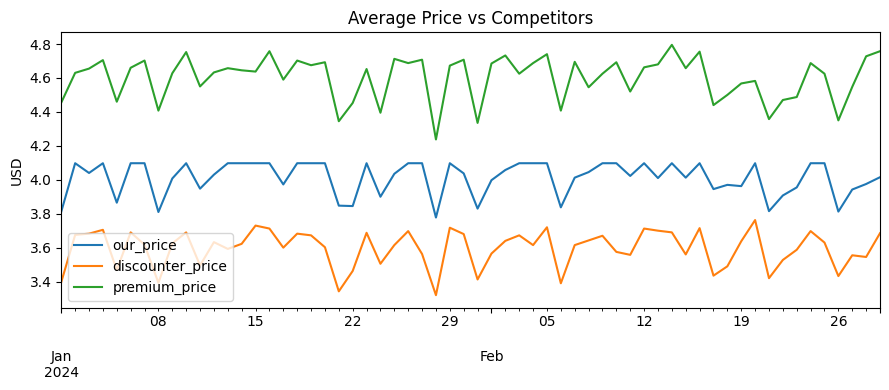

In [26]:
#First Plot 
# How do our prices compare to competitors day-to-day?
daily = df.groupby("date")[["our_price","discounter_price","premium_price"]].mean()

ax = daily.plot(figsize=(9,4), title="Average Price vs Competitors")
plt.ylabel("USD"); plt.xlabel("")
plt.tight_layout()
plt.savefig("../reports/figures/price_vs_competitors.png", dpi=180)
plt.show()


In [30]:
# On what % of days are we cheaper than the discounter / premium?
share_cheaper_disc = (df["our_price"] < df["discounter_price"]).mean()
share_cheaper_prem = (df["our_price"] < df["premium_price"]).mean()
share_between      = ((df["our_price"] >= df["discounter_price"]) & (df["our_price"] <= df["premium_price"])).mean()

summary_pos = pd.DataFrame({
    "metric": ["Pct cheaper vs discounter", "Pct cheaper vs premium", "Pct between both"],
    "value": [share_cheaper_disc, share_cheaper_prem, share_between]
})
summary_pos

,metric,value
0,Pct cheaper vs discounter,0.0
1,Pct cheaper vs premium,1.0
2,Pct between both,1.0


In [15]:
# Do promotions actually move units? By how much?
promo = df.groupby("on_promo")[["our_price","units_sold","revenue"]].mean().rename(index={0:"No Promo",1:"Promo"})
promo["units_lift_vs_no_promo_%"] = (promo.loc["Promo","units_sold"] / promo.loc["No Promo","units_sold"] - 1) * 100
promo

,our_price,units_sold,revenue,units_lift_vs_no_promo_%
on_promo,,,,
No Promo,4.122500,42.109375,176.629635,10.47619
Promo,3.567083,46.520833,168.719792,10.47619


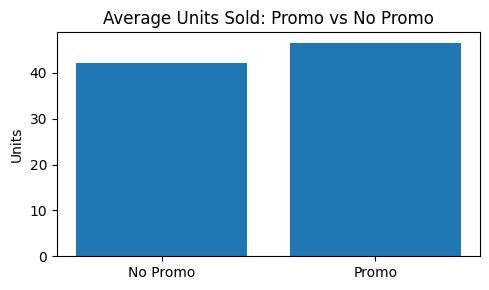

In [29]:
# quick bar chart of avg units sold by promo
vals = df.groupby("on_promo")["units_sold"].mean().reindex([0,1])
plt.figure(figsize=(5,3))
plt.bar(["No Promo","Promo"], vals.values)
plt.title("Average Units Sold: Promo vs No Promo")
plt.ylabel("Units")
plt.tight_layout()
plt.savefig("../reports/figures/promo_units_bar.png", dpi=180)
plt.show()


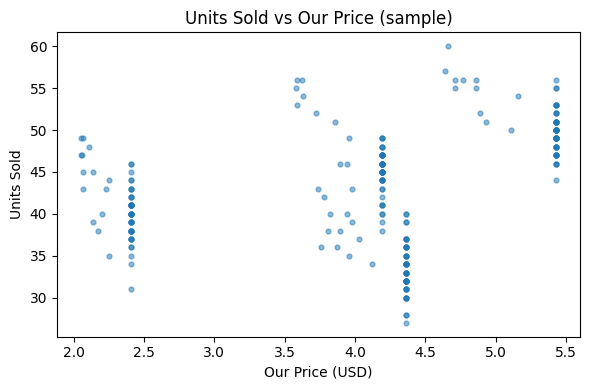

In [18]:
# Do higher prices correlate with fewer units?
sample = df.sample(min(600, len(df)), random_state=0)

plt.figure(figsize=(6,4))
plt.scatter(sample["our_price"], sample["units_sold"], alpha=0.5, s=12)
plt.title("Units Sold vs Our Price (sample)")
plt.xlabel("Our Price (USD)"); plt.ylabel("Units Sold"); plt.tight_layout()
plt.savefig("../reports/figures/units_vs_price_scatter.png", dpi=180); plt.show()

In [19]:
# Roughly, how sensitive is demand to price in each category?
import numpy as np
results = []

for cat, g in df[df["units_sold"] > 0].groupby("category"):
    x = np.log(g["our_price"].values)
    y = np.log(g["units_sold"].values)
    if len(g) > 5 and np.isfinite(x).all() and np.isfinite(y).all():
        slope, intercept = np.polyfit(x, y, 1)  # y = intercept + slope * x
        results.append({"category": cat, "elasticity_approx": slope})
        
elasticity = pd.DataFrame(results).sort_values("elasticity_approx")
elasticity

,category,elasticity_approx
0,almond_milk,-1.238201
1,kombucha,-1.157413
3,protein_shake,-0.862812
2,oat_milk,-0.861527


In [21]:
# If we cut price by 5%, does revenue go up or down given elasticity?
def revenue_change(price, units, elasticity, pct_change_price=-0.05):
    # percent change in units ≈ elasticity * percent change in price
    new_price = price * (1 + pct_change_price)
    units_change_pct = elasticity * pct_change_price
    new_units = units * (1 + units_change_pct)
    return (new_price * new_units) - (price * units)

# compute per-category avg baseline, then simulate
sim_rows = []
for _, row in elasticity.iterrows():
    cat = row["category"]; e = row["elasticity_approx"]
    g = df[df["category"] == cat]
    base_price = g["our_price"].mean()
    base_units = g["units_sold"].mean()
    delta_rev = revenue_change(base_price, base_units, e, pct_change_price=-0.05)
    sim_rows.append({"category": cat, "elasticity": e, "baseline_price": base_price, "baseline_units": base_units,
                     "delta_rev_if_price_cut_5usd_pct": 100 * (delta_rev / (base_price * base_units))})

sim = pd.DataFrame(sim_rows).sort_values("delta_rev_if_price_cut_5usd_pct", ascending=False)
sim


,category,elasticity,baseline_price,baseline_units,delta_rev_if_price_cut_5usd_pct
0,almond_milk,-1.238201,4.111167,46.100000,0.881454
1,kombucha,-1.157413,4.266333,34.500000,0.497710
2,protein_shake,-0.862812,2.345333,40.716667,-0.901644
3,oat_milk,-0.861527,5.322833,50.650000,-0.907747


In [32]:
import os
os.makedirs("../reports/tables", exist_ok=True)
summary_pos.to_csv("../reports/tables/positioning_summary.csv", index=False)
promo.to_csv("../reports/tables/promo_summary.csv")
elasticity.to_csv("../reports/tables/elasticity_estimates.csv", index=False)
sim.to_csv("../reports/tables/what_if_5pct_cut.csv", index=False)
"Saved tables and figures to reports/ "

'Saved tables and figures to reports/ '